Epoch 1/10, Loss: 0.3098
Epoch 2/10, Loss: 0.1359
Epoch 3/10, Loss: 0.1010
Epoch 4/10, Loss: 0.0820
Epoch 5/10, Loss: 0.0683
Epoch 6/10, Loss: 0.0590
Epoch 7/10, Loss: 0.0558
Epoch 8/10, Loss: 0.0498
Epoch 9/10, Loss: 0.0440
Epoch 10/10, Loss: 0.0422
⏱ Время обучения: 99.40 сек
🎯 Точность на тесте: 98.07%


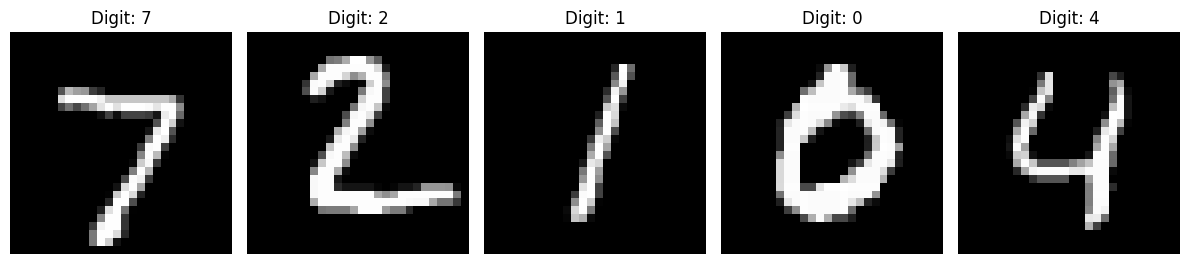

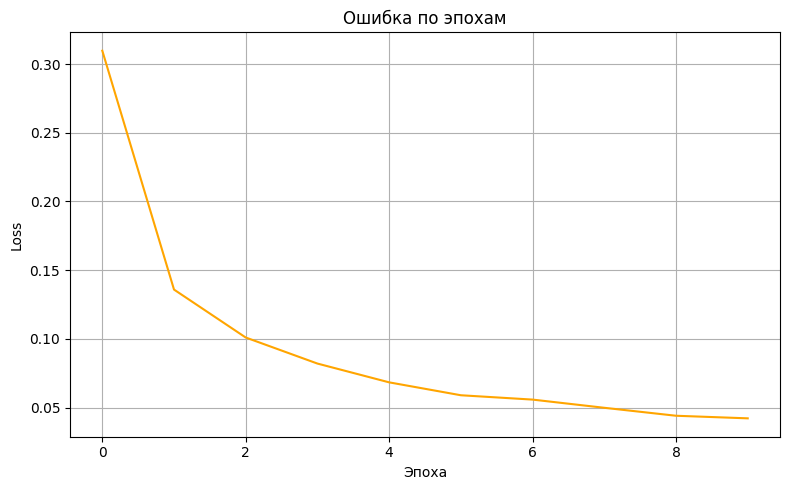

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time, os
import numpy as np

# === 1. Настройки ===
BATCH_SIZE = 128
EPOCHS = 10
LR = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 2. Трансформации ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # нормализация MNIST
])

# === 3. Датасеты ===
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# === 4. Модель ===
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)  # 10 классов
        )
    def forward(self, x):
        return self.net(x)

model = MNISTClassifier().to(device)

# === 5. Оптимизатор и Loss ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# === 6. Обучение ===
losses = []
start = time.time()

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {losses[-1]:.4f}")

end = time.time()

# === 7. Оценка ===
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()

accuracy = correct / total
print(f"⏱ Время обучения: {end-start:.2f} сек")
print(f"🎯 Точность на тесте: {accuracy*100:.2f}%")
# === 9. Визуализация угаданных цифр ===


# Берём батч из теста
model.eval()
with torch.no_grad():
    xb, yb = next(iter(test_loader))
    xb, yb = xb.to(device), yb.to(device)
    outputs = model(xb)
    _, predicted = torch.max(outputs, 1)

# Отбираем только угаданные примеры
correct_idx = (predicted == yb).nonzero(as_tuple=True)[0]

# Берём первые 5 угаданных
samples = correct_idx[:5].cpu().numpy()

plt.figure(figsize=(12, 4))
for i, idx in enumerate(samples):
    img = xb[idx].cpu().squeeze().numpy()  # 28x28
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Digit: {predicted[idx].item()}")
    plt.axis("off")

plt.tight_layout()
plt.savefig("results/mnist_correct_samples.png")
plt.show()



# === 8. Визуализация ===
os.makedirs("results", exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(losses, color="orange")
plt.title("Ошибка по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/mnist_loss_curve.png")


🚀 Используем GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Epoch 1/10, Loss: 0.1720
Epoch 2/10, Loss: 0.0559
Epoch 3/10, Loss: 0.0397
Epoch 4/10, Loss: 0.0315
Epoch 5/10, Loss: 0.0255
Epoch 6/10, Loss: 0.0214
Epoch 7/10, Loss: 0.0184
Epoch 8/10, Loss: 0.0171
Epoch 9/10, Loss: 0.0146
Epoch 10/10, Loss: 0.0131
⏱ Время обучения: 144.85 сек
🎯 Точность на тесте: 99.11%

Примеры предсказаний:
Предсказано: 7, Реальное: 7
Предсказано: 2, Реальное: 2
Предсказано: 1, Реальное: 1
Предсказано: 0, Реальное: 0
Предсказано: 4, Реальное: 4


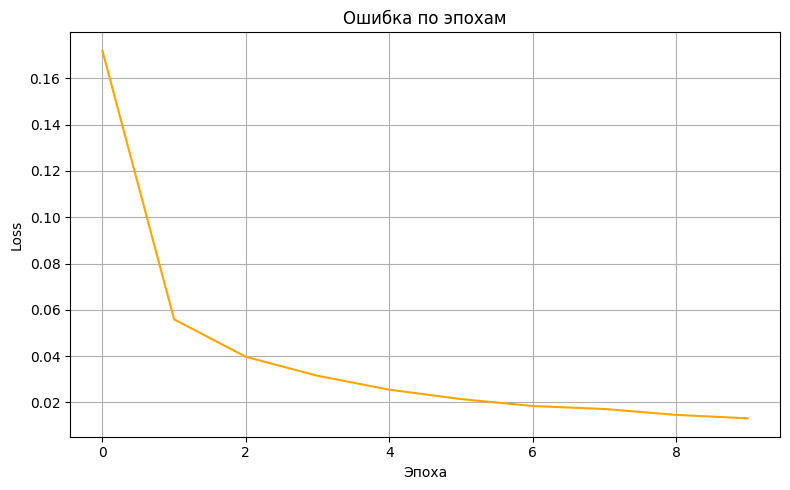

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time, os

# === 1. Настройки ===
BATCH_SIZE = 128
EPOCHS = 10
LR = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print(f"🚀 Используем GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚙️ Используем CPU")


# === 2. Трансформации ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# === 3. Датасеты ===
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# === 4. Модель CNN ===
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # 28x28 -> 32 feature maps
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 feature maps
        self.pool = nn.MaxPool2d(2, 2)  # уменьшение размерности
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # 64 каналов * 14 * 14 = 12544
        self.fc2 = nn.Linear(128, 10)   # 10 классов

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # разворачиваем в вектор
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)

# === 5. Loss и Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# === 6. Обучение ===
losses = []
start = time.time()

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        yb = yb.view(-1).long()   # гарантируем правильный тип меток
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {losses[-1]:.4f}")

end = time.time()

# === 7. Оценка ===
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        yb = yb.view(-1).long()
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()

accuracy = correct / total
print(f"⏱ Время обучения: {end-start:.2f} сек")
print(f"🎯 Точность на тесте: {accuracy*100:.2f}%")

# === 8. Примеры предсказаний ===
print("\nПримеры предсказаний:")
with torch.no_grad():
    xb, yb = next(iter(test_loader))
    xb, yb = xb.to(device), yb.to(device)
    outputs = model(xb)
    _, predicted = torch.max(outputs, 1)
    for i in range(5):
        print(f"Предсказано: {predicted[i].item()}, Реальное: {yb[i].item()}")

# === 9. График ошибки ===
os.makedirs("results", exist_ok=True)
plt.figure(figsize=(8,5))
plt.plot(losses, color="orange")
plt.title("Ошибка по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/mnist_cnn_loss_curve.png")
plt.show()


🚀 Используем GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Epoch 1/10, Loss: 0.1672
Epoch 2/10, Loss: 0.0541
Epoch 3/10, Loss: 0.0399
Epoch 4/10, Loss: 0.0296
Epoch 5/10, Loss: 0.0246
Epoch 6/10, Loss: 0.0204
Epoch 7/10, Loss: 0.0175
Epoch 8/10, Loss: 0.0141
Epoch 9/10, Loss: 0.0153
Epoch 10/10, Loss: 0.0118
⏱ Время обучения: 142.42 сек
🎯 Точность на тесте: 99.14%

Примеры предсказаний:
Предсказано: 7, Реальное: 7
Предсказано: 2, Реальное: 2
Предсказано: 1, Реальное: 1
Предсказано: 0, Реальное: 0
Предсказано: 4, Реальное: 4


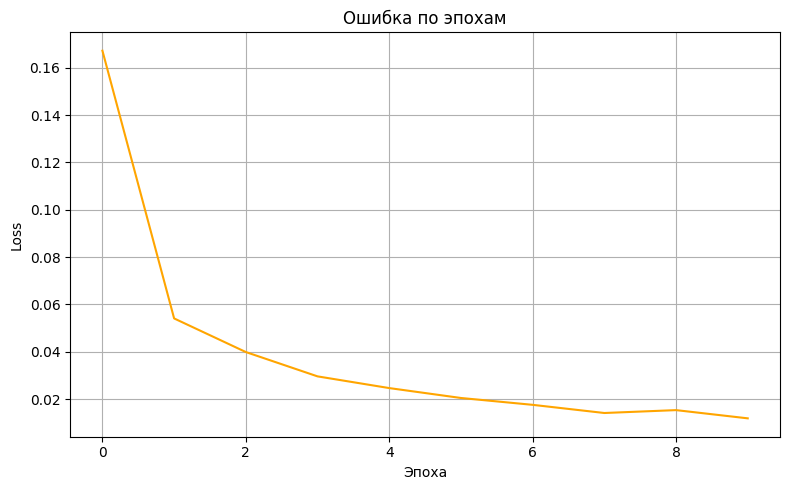

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time, os

# === 1. Настройки ===
BATCH_SIZE = 128
EPOCHS = 10
LR = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print(f"🚀 Используем GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚙️ Используем CPU")


# === 2. Трансформации ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# === 3. Датасеты ===
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# === 4. Модель CNN ===
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # 28x28 -> 32 feature maps
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 feature maps
        self.pool = nn.MaxPool2d(2, 2)  # уменьшение размерности
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # 64 каналов * 14 * 14 = 12544
        self.fc2 = nn.Linear(128, 10)   # 10 классов

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # разворачиваем в вектор
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)

# === 5. Loss и Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# === 6. Обучение ===
losses = []
start = time.time()

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        yb = yb.view(-1).long()   # гарантируем правильный тип меток
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {losses[-1]:.4f}")

end = time.time()

# === 7. Оценка ===
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        yb = yb.view(-1).long()
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()

accuracy = correct / total
print(f"⏱ Время обучения: {end-start:.2f} сек")
print(f"🎯 Точность на тесте: {accuracy*100:.2f}%")

# === 8. Примеры предсказаний ===
print("\nПримеры предсказаний:")
with torch.no_grad():
    xb, yb = next(iter(test_loader))
    xb, yb = xb.to(device), yb.to(device)
    outputs = model(xb)
    _, predicted = torch.max(outputs, 1)
    for i in range(5):
        print(f"Предсказано: {predicted[i].item()}, Реальное: {yb[i].item()}")

# === 9. График ошибки ===
os.makedirs("results", exist_ok=True)
plt.figure(figsize=(8,5))
plt.plot(losses, color="orange")
plt.title("Ошибка по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/mnist_cnn_loss_curve.png")
plt.show()


Свёрточная нейронная сеть (Convolutional Neural Network, CNN) — это архитектура, специально созданная для работы с изображениями и данными, где важен локальный контекст (соседние пиксели, временные точки, пространственные зависимости).

🧩 Основные блоки
Слой свёртки (Conv2d) Извлекает признаки с помощью фильтров (ядер). Каждый фильтр «видит» локальный участок изображения и учится распознавать простые паттерны (линии, углы, текстуры).

Функция активации (ReLU) Вносит нелинейность, чтобы сеть могла учиться сложным зависимостям.

Pooling (MaxPool, AvgPool) Уменьшает размерность, сохраняя важные признаки (downsampling).

Dropout Регуляризация, отключает случайные нейроны для борьбы с переобучением.

Полносвязные слои (fc1, fc2) Собирают признаки и принимают финальное решение (например, классификация цифры 0–9).
Stride (шаг фильтра)
Определение: это шаг, с которым фильтр (ядро свёртки) перемещается по изображению.

По умолчанию: stride=1 → фильтр двигается на 1 пиксель.

Если stride=2 → фильтр «перепрыгивает» через пиксели, уменьшая размер выходной карты признаков.

Эффект: stride управляет downsampling’ом (сжатием изображения).

📐 Пример: Вход: 7×7, ядро 3×3, stride=1 → выход 5×5. Вход: 7×7, ядро 3×3, stride=2 → выход 3×3.

Padding (дополнение краёв)
Определение: это добавление рамки вокруг изображения (обычно нулей), чтобы контролировать размер выхода.

Без padding (padding=0): размер уменьшается после каждой свёртки.

С padding: можно сохранить размер входа.

Например, при kernel=3, stride=1, padding=1 размер остаётся тем же.

Эффект: padding позволяет:

сохранить информацию с краёв изображения;

контролировать глубину сети (без слишком быстрого уменьшения размерности);

реализовать режимы:

valid convolution (без padding, размер уменьшается),

same convolution (padding подбирается так, чтобы размер сохранялся).

🧩 Пример на MNIST (28×28)
Conv2d(1, 32, kernel_size=3, stride=1, padding=1) → выход: 28×28 (размер сохраняется).

Conv2d(1, 32, kernel_size=3, stride=1, padding=0) → выход: 26×26 (уменьшился).

Conv2d(1, 32, kernel_size=3, stride=2, padding=1) → выход: 14×14 (downsampling).

⚡ Практическое использование
Stride=1, Padding=1 (при kernel=3) — стандарт в современных CNN (VGG, ResNet), чтобы глубина не уменьшала размерность слишком быстро.

Stride>1 — используется для уменьшения размерности (альтернатива pooling).

Padding=0 — иногда применяют в старых архитектурах (LeNet) или когда нужно уменьшить размер карты признаков.

👉 Таким образом:

Stride управляет тем, насколько быстро уменьшается размер карты признаков.

Padding управляет тем, сохраняем ли мы размерность и учитываем ли края изображения.

🏗️ Популярные архитектуры CNN
| Архитектура  | Год  | Особенности                            | На чём обучали | Основное применение                  |
|--------------|------|----------------------------------------|----------------|--------------------------------------|
| LeNet-5      | 1998 | Первая CNN, простая структура          | MNIST          | Распознавание рукописных цифр        |
| AlexNet      | 2012 | ReLU, Dropout, обучение на GPU         | ImageNet       | Классификация изображений            |
| VGGNet       | 2014 | Только 3×3 свёртки, глубина до 19      | ImageNet       | Классификация, извлечение признаков  |
| GoogLeNet    | 2014 | Inception-модули (разные ядра паралл.) | ImageNet       | Классификация, детекция объектов     |
| ResNet       | 2015 | Residual connections (skip-connections)| ImageNet       | Классификация, сегментация           |
| DenseNet     | 2017 | Каждый слой связан со всеми предыдущими| ImageNet       | Сегментация, медицина                |
| EfficientNet | 2019 | Баланс глубины, ширины и разрешения    | ImageNet       | Мобильные устройства, быстрые модели |

![Схемы моделей](cnn.png)

🎯 Где применяют CNN
Компьютерное зрение: классификация, детекция объектов, сегментация.

Медицина: анализ рентгенов, МРТ, КТ.

Автопилоты: распознавание дорожных знаков, разметки.

Биометрия: распознавание лиц, отпечатков.

Искусство: стилизация изображений, генерация картин.

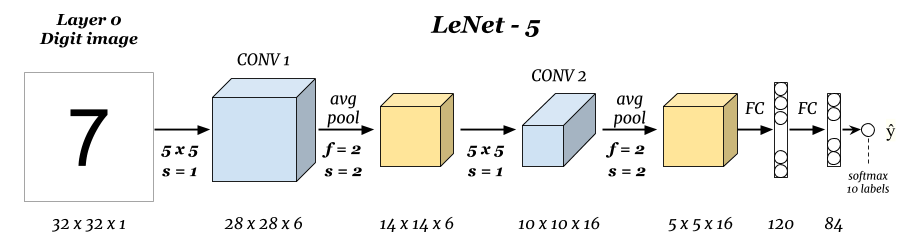

In [18]:
from IPython.display import Image, display

display(Image(filename='LeNet.png'))

📚 Что из себя представляет LeNet‑5
Год: 1998

Авторы: Ян ЛеКун, Леон Ботту, Йошуа Бенджио, Патрик Хаффнер.

Задача: распознавание рукописных цифр (MNIST, почтовые индексы).

Архитектура:

Вход: изображение 32×32 (в оригинале цифры MNIST дополнялись до этого размера).
C1: Conv слой — 6 фильтров 5×5 → выход 28×28×6.
S2: Subsampling (Average Pooling) — 2×2, stride=2 → выход 14×14×6.
C3: Conv слой — 16 фильтров 5×5 → выход 10×10×16.
S4: Subsampling — 2×2 → выход 5×5×16.
C5: Conv слой (фактически FC) — 120 фильтров 5×5 → выход 1×1×120.
F6: Fully Connected — 84 нейрона.
Output — 10 нейронов (Softmax для цифр 0–9).

🎯 Для чего используется

Классификация рукописных цифр (MNIST).
Образовательные цели: LeNet — «первая успешная CNN», её часто изучают как базовую архитектуру.
Историческая база: многие современные CNN (AlexNet, VGG, ResNet) выросли из идей LeNet.
Применение в 90‑е: распознавание почтовых индексов и чеков.

⏳ Актуальна ли сейчас

В продакшене: нет, слишком простая и слабая для современных задач.
В обучении: да, это классика, с которой начинают изучение CNN.
Влияние: LeNet показала, что свёрточные сети реально работают, и стала фундаментом для всей области компьютерного зрения.

📊 Итог

LeNet‑5 — первая по‑настоящему успешная CNN.
Сегодня она уступает по точности и мощности, но остаётся важной в истории и обучении.
Её структура (Conv → Pool → Conv → Pool → FC → Output) стала «шаблоном» для всех последующих архитектур.

=== LeNet-5 на MNIST ===
Epoch 1/10: Train loss=0.3050, Test loss=0.1020, Acc=96.54%, Time=16.27 sec
Epoch 2/10: Train loss=0.0878, Test loss=0.0537, Acc=98.31%, Time=17.31 sec
Epoch 3/10: Train loss=0.0623, Test loss=0.0519, Acc=98.23%, Time=15.55 sec
Epoch 4/10: Train loss=0.0499, Test loss=0.0425, Acc=98.59%, Time=16.09 sec
Epoch 5/10: Train loss=0.0417, Test loss=0.0422, Acc=98.69%, Time=16.98 sec
Epoch 6/10: Train loss=0.0357, Test loss=0.0380, Acc=98.81%, Time=15.43 sec
Epoch 7/10: Train loss=0.0308, Test loss=0.0417, Acc=98.69%, Time=15.49 sec
Epoch 8/10: Train loss=0.0275, Test loss=0.0351, Acc=98.93%, Time=15.40 sec
Epoch 9/10: Train loss=0.0229, Test loss=0.0353, Acc=98.85%, Time=16.84 sec
Epoch 10/10: Train loss=0.0205, Test loss=0.0312, Acc=99.05%, Time=16.22 sec


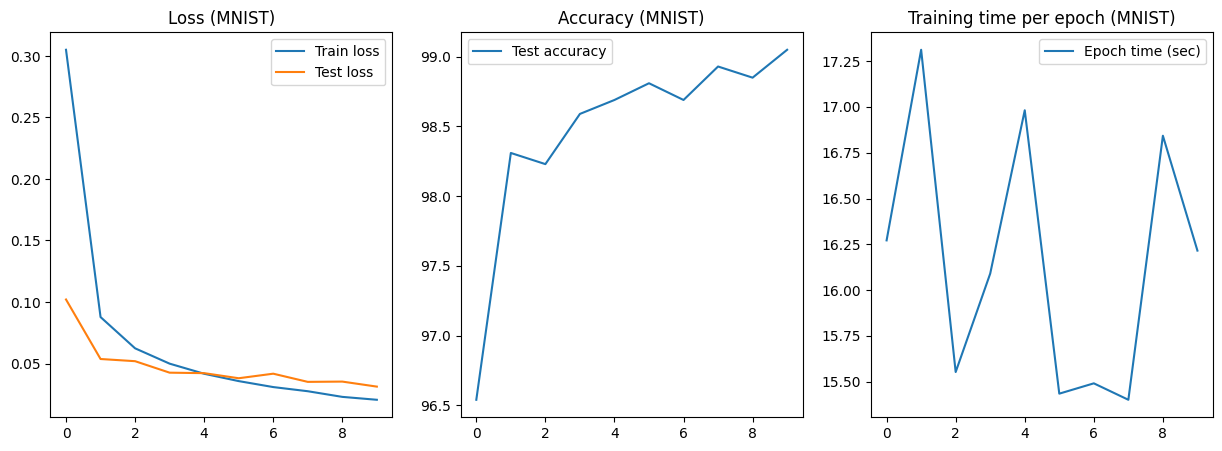

=== LeNet-5 на Fashion-MNIST ===
Epoch 1/10: Train loss=0.6810, Test loss=0.5322, Acc=80.15%, Time=15.71 sec
Epoch 2/10: Train loss=0.4588, Test loss=0.4353, Acc=84.16%, Time=15.95 sec
Epoch 3/10: Train loss=0.3971, Test loss=0.3938, Acc=85.60%, Time=16.50 sec
Epoch 4/10: Train loss=0.3594, Test loss=0.3669, Acc=86.50%, Time=16.29 sec
Epoch 5/10: Train loss=0.3334, Test loss=0.3623, Acc=86.80%, Time=17.15 sec
Epoch 6/10: Train loss=0.3133, Test loss=0.3391, Acc=87.55%, Time=16.00 sec
Epoch 7/10: Train loss=0.2938, Test loss=0.3251, Acc=88.06%, Time=17.16 sec
Epoch 8/10: Train loss=0.2799, Test loss=0.3299, Acc=87.79%, Time=15.60 sec
Epoch 9/10: Train loss=0.2653, Test loss=0.3104, Acc=88.50%, Time=15.47 sec
Epoch 10/10: Train loss=0.2559, Test loss=0.2986, Acc=89.30%, Time=15.41 sec


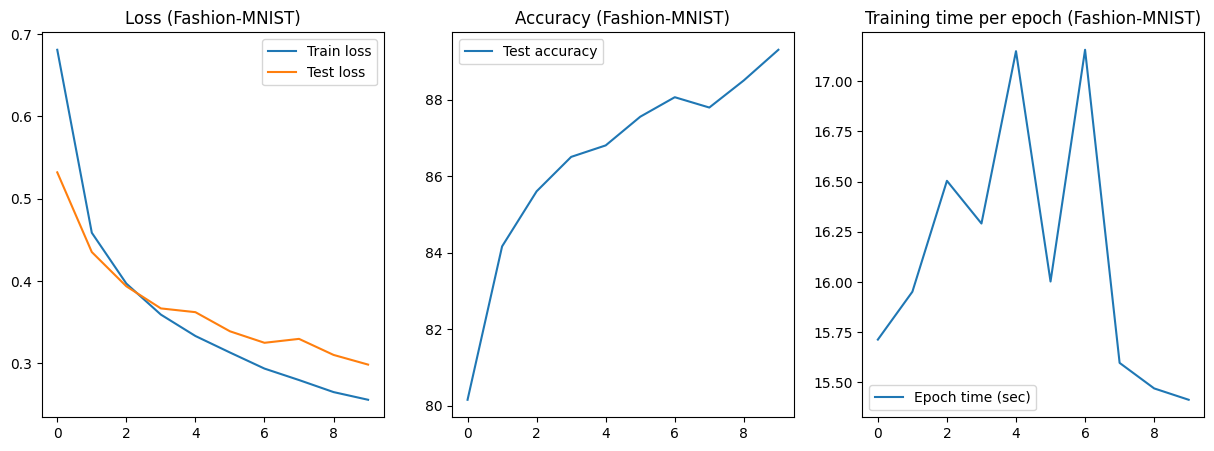

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# --- 1. Подготовка данных ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_fashion = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_mnist, batch_size=64, shuffle=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=1000, shuffle=False)

train_loader_fashion = DataLoader(train_fashion, batch_size=64, shuffle=True)
test_loader_fashion = DataLoader(test_fashion, batch_size=1000, shuffle=False)

# --- 2. Определение модели LeNet-5 ---
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 28→24→12
        x = self.pool(F.relu(self.conv2(x)))   # 12→8→4
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# --- 3. Функция обучения с замером времени ---
def train_and_evaluate(train_loader, test_loader, epochs=10, title="MNIST"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LeNet5().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, test_accs, times = [], [], [], []

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        running_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_loader))

        # --- Оценка ---
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        epoch_time = time.time() - start_time
        times.append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train loss={train_losses[-1]:.4f}, "
              f"Test loss={test_losses[-1]:.4f}, "
              f"Acc={test_accs[-1]:.2f}%, "
              f"Time={epoch_time:.2f} sec")

    # --- Графики ---
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.title(f"Loss ({title})")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(test_accs, label="Test accuracy")
    plt.title(f"Accuracy ({title})")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(times, label="Epoch time (sec)")
    plt.title(f"Training time per epoch ({title})")
    plt.legend()

    plt.show()

# --- 4. Запуск обучения ---
print("=== LeNet-5 на MNIST ===")
train_and_evaluate(train_loader_mnist, test_loader_mnist, epochs=10, title="MNIST")

print("=== LeNet-5 на Fashion-MNIST ===")
train_and_evaluate(train_loader_fashion, test_loader_fashion, epochs=10, title="Fashion-MNIST")


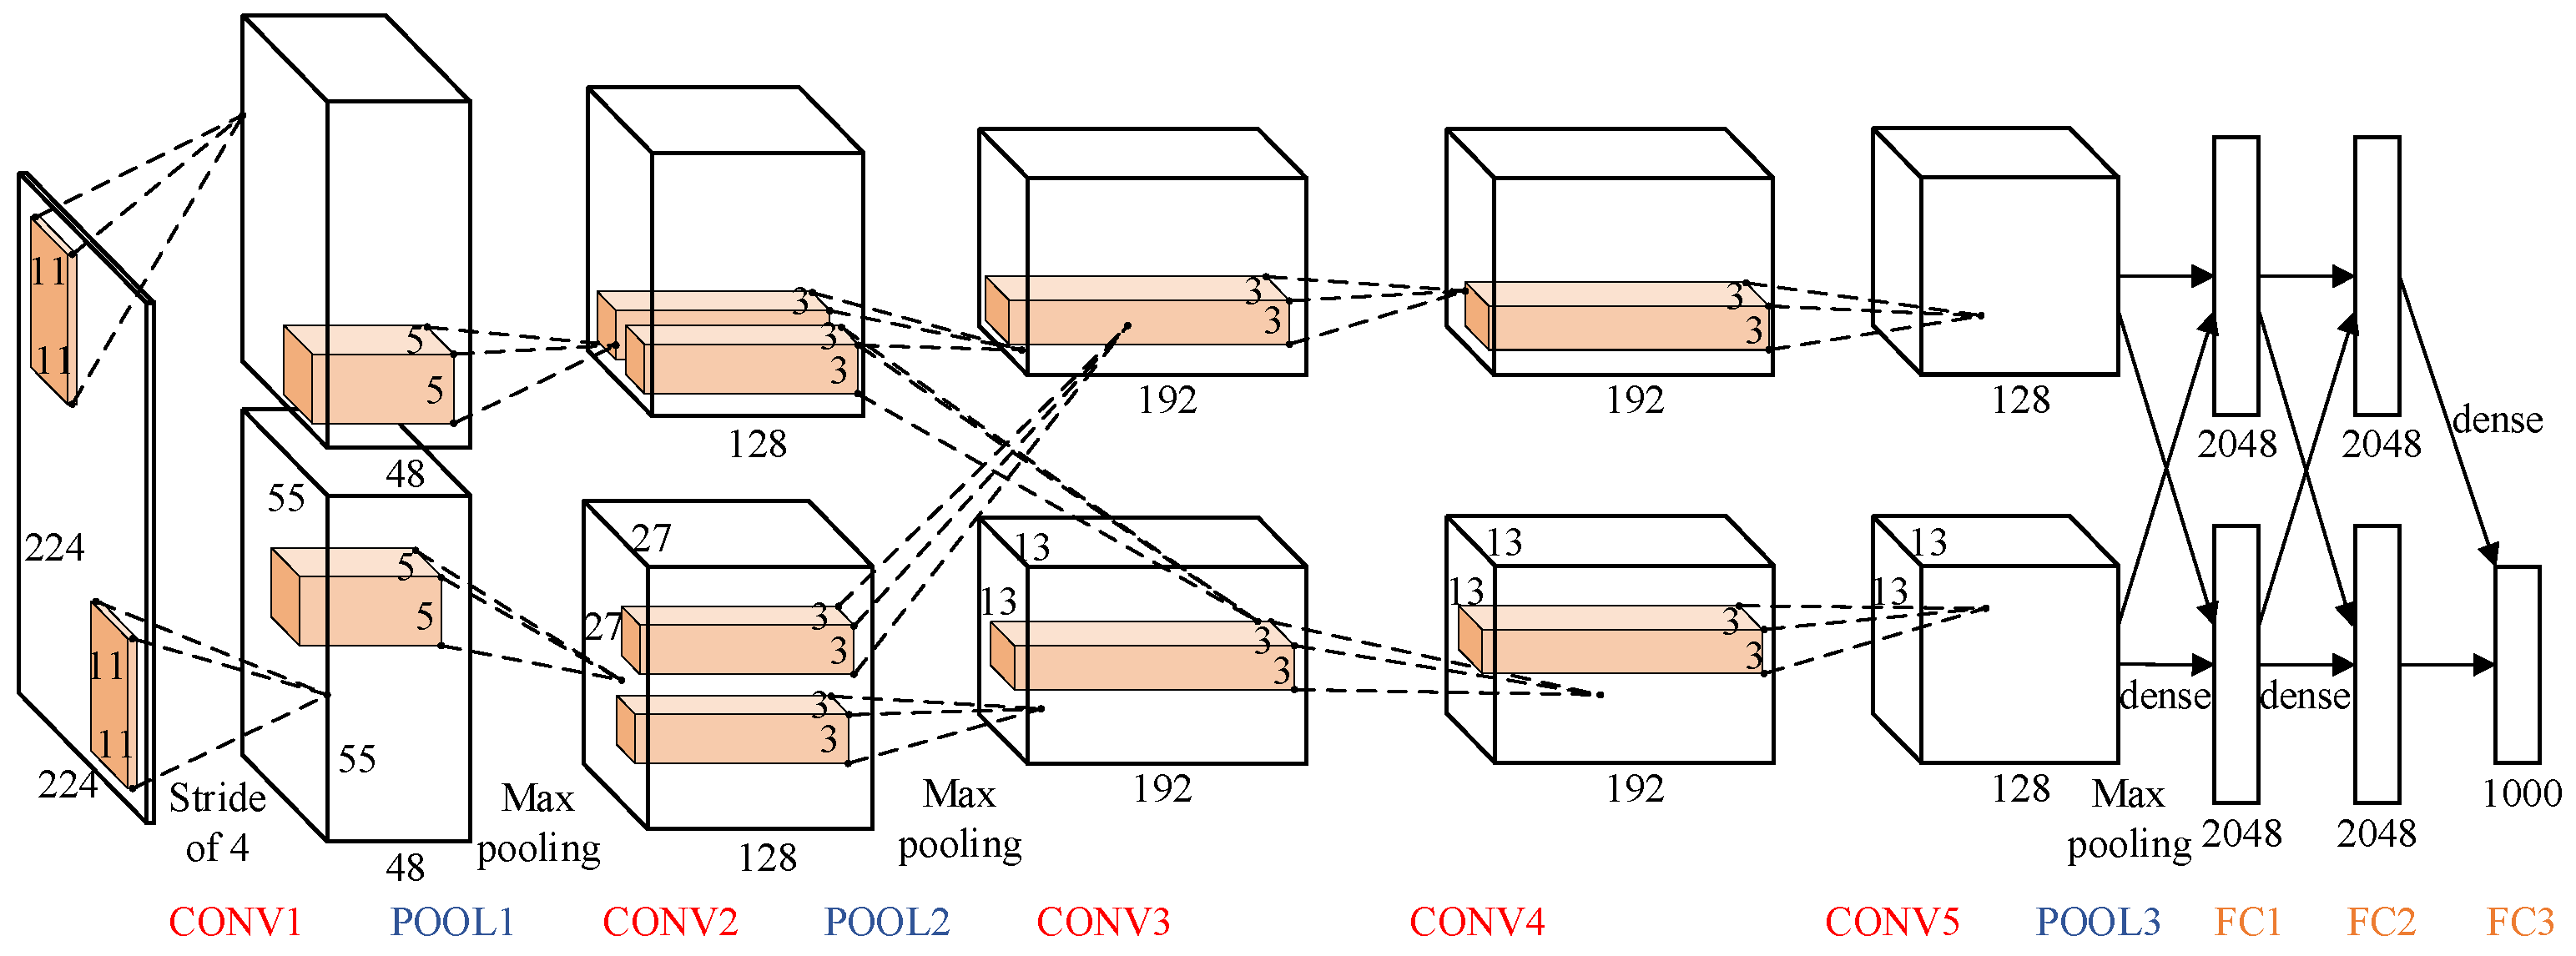

In [12]:
from IPython.display import Image, display

display(Image(filename='AlexNet.png'))


Что из себя представляет AlexNet
Год: 2012

Авторы: Алекс Крижевский, Илья Сутскевер, Джеффри Хинтон

Прорыв: победа в конкурсе ImageNet Large Scale Visual Recognition Challenge (ILSVRC‑2012) с огромным отрывом (ошибка снизилась с ~26% до ~15%).

Архитектура:

Вход: изображение 224×224×3 (RGB).
5 свёрточных слоёв (Conv), часть из них с крупными ядрами (например, 11×11 в первом слое).
MaxPooling после некоторых Conv.
ReLU как функция активации (новшество на тот момент, ускорило обучение).
Dropout для борьбы с переобучением.
3 полносвязных слоя (4096 → 4096 → 1000).
Выход: 1000 классов (ImageNet).

Особенность: обучение на двух GPU (тогда это было революцией).

🎯 Для чего используется

Классификация изображений (ImageNet, CIFAR, MNIST и др.).
Фича‑экстрактор: свёрточные слои AlexNet можно использовать для извлечения признаков и применять в других задачах (детекция, сегментация).
Образовательные цели: часто используется как «Hello World» в глубоких CNN, чтобы показать переход от классических методов к глубокому обучению.
Историческая база: многие современные архитектуры (VGG, ResNet, DenseNet) выросли из идей AlexNet.

⏳ Актуальна ли сейчас

Для практики: нет, в продакшене AlexNet почти не используют. Она слишком «тяжёлая» (60 млн параметров) и менее точная, чем современные модели.
Для обучения: да, это классика, с которой начинают изучение CNN.
Для исследований: служит «контрольной точкой» — на ней часто тестируют новые идеи, чтобы сравнить с историческим baseline.
Влияние: именно AlexNet доказала, что глубокие сети реально работают на больших данных и GPU, и запустила «взрыв» в области компьютерного зрения.

⚡ Итог

AlexNet — это «отец» современных CNN.
Сегодня она уступает по точности и эффективности (ResNet, EfficientNet, Vision Transformers), но остаётся важной в истории и обучении.
Если ты строишь что‑то для реального применения — лучше взять ResNet или EfficientNet. Если хочешь понять основы — AlexNet идеальна.

=== AlexNet на MNIST ===
Epoch 1/3: Train loss=0.2784, Test loss=0.0798, Acc=97.74%, Time=180.49 sec
Epoch 2/3: Train loss=0.0953, Test loss=0.0484, Acc=98.64%, Time=381.99 sec
Epoch 3/3: Train loss=0.0709, Test loss=0.0462, Acc=98.62%, Time=372.94 sec


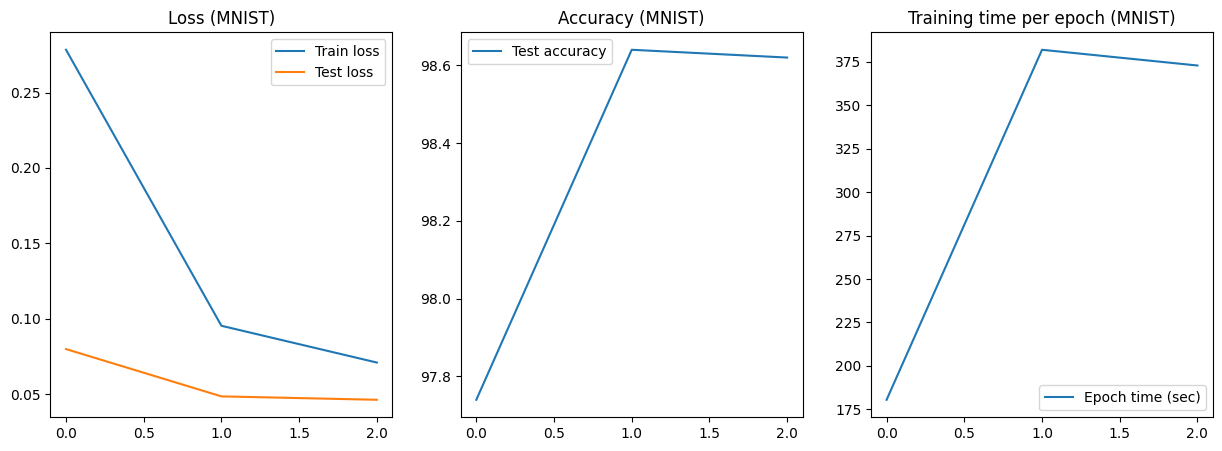

=== AlexNet на Fashion-MNIST ===
Epoch 1/3: Train loss=0.5754, Test loss=0.3690, Acc=86.16%, Time=618.12 sec
Epoch 2/3: Train loss=0.3715, Test loss=0.3579, Acc=87.17%, Time=595.50 sec
Epoch 3/3: Train loss=0.3387, Test loss=0.3123, Acc=88.21%, Time=598.46 sec


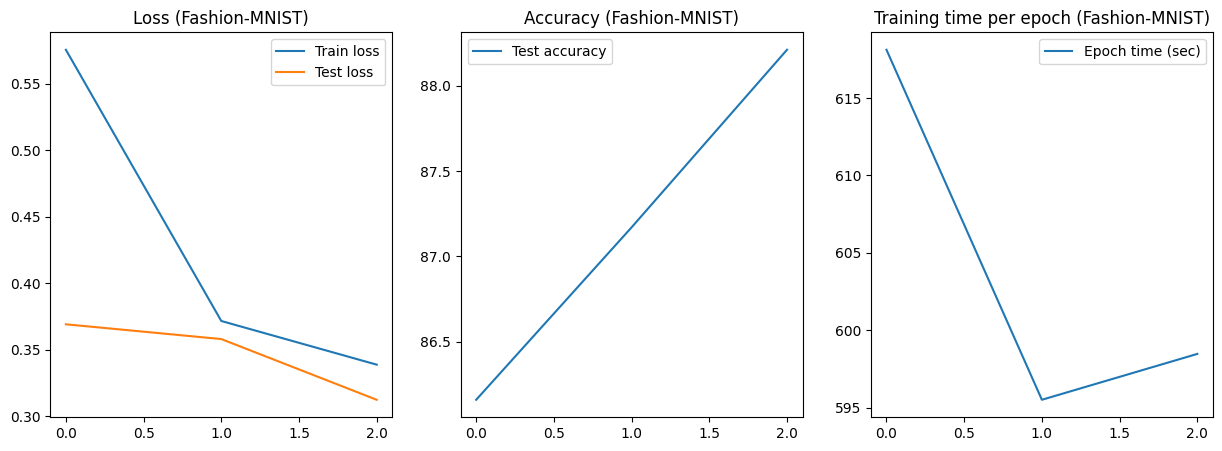

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# --- 1. Подготовка данных ---
transform = transforms.Compose([
    transforms.Resize(224),   # AlexNet ожидает 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_fashion = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_mnist, batch_size=64, shuffle=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=1000, shuffle=False)

train_loader_fashion = DataLoader(train_fashion, batch_size=64, shuffle=True)
test_loader_fashion = DataLoader(test_fashion, batch_size=1000, shuffle=False)

# --- 2. Определение AlexNet ---
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),  # in_channels=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# --- 3. Функция обучения ---
def train_and_evaluate(train_loader, test_loader, epochs=10, title="MNIST"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AlexNet(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, test_accs, times = [], [], [], []

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        running_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_loader))

        # --- Оценка ---
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        epoch_time = time.time() - start_time
        times.append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train loss={train_losses[-1]:.4f}, "
              f"Test loss={test_losses[-1]:.4f}, "
              f"Acc={test_accs[-1]:.2f}%, "
              f"Time={epoch_time:.2f} sec")

    # --- Графики ---
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.title(f"Loss ({title})")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(test_accs, label="Test accuracy")
    plt.title(f"Accuracy ({title})")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(times, label="Epoch time (sec)")
    plt.title(f"Training time per epoch ({title})")
    plt.legend()

    plt.show()

# --- 4. Запуск обучения ---
print("=== AlexNet на MNIST ===")
train_and_evaluate(train_loader_mnist, test_loader_mnist, epochs=3, title="MNIST")

print("=== AlexNet на Fashion-MNIST ===")
train_and_evaluate(train_loader_fashion, test_loader_fashion, epochs=3, title="Fashion-MNIST")


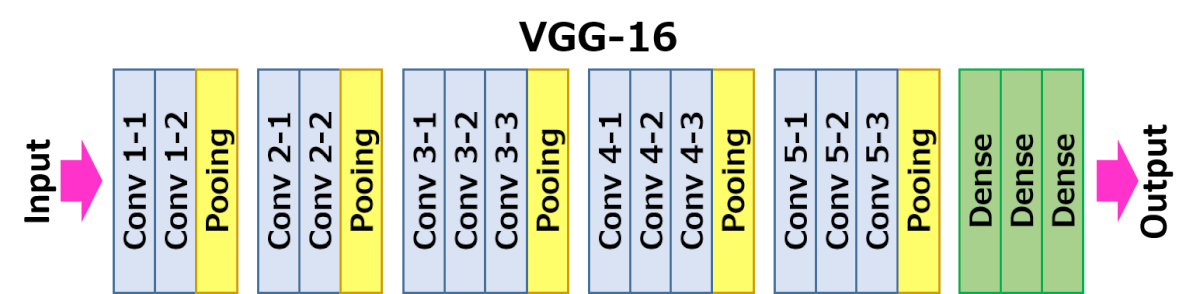

In [13]:
from IPython.display import Image, display

display(Image(filename='VGGNet.png'))


📚 Что из себя представляет VGGNet
Год: 2014
Авторы: Карен Симонян и Эндрю Зиссерман (Visual Geometry Group, Оксфордский университет).
Прорыв: показала, что глубина сети напрямую улучшает качество распознавания.

Архитектура:

Вход: изображение 224×224×3 (RGB).
Используются только свёртки 3×3 (с padding=1, stride=1) и pooling 2×2.
Две основные версии: VGG‑16 (13 conv + 3 FC) и VGG‑19 (16 conv + 3 FC).
После каждого блока Conv идёт MaxPool, уменьшающий размер карты признаков.
В конце — 3 полносвязных слоя (4096 → 4096 → 1000).
Особенность: простая и единообразная структура (все conv одинакового размера).

🎯 Для чего используется

Классификация изображений (ImageNet, CIFAR и др.).
Feature extractor: свёрточные блоки VGG часто используют для извлечения признаков в задачах детекции (Faster R‑CNN), сегментации (FCN, U‑Net).
Transfer learning: предобученные веса VGG доступны в torchvision.models и Keras, их часто используют для дообучения на новых датасетах.
Исследования: VGG стала «эталоном» для сравнения новых архитектур.

⏳ Актуальна ли сейчас

В продакшене: почти не используется, потому что слишком тяжёлая (VGG‑16 ≈ 138 млн параметров).
Для обучения: да, это классика, которая помогает понять, как глубина влияет на качество.
Влияние: идеи VGG (малые ядра 3×3, глубокая структура) легли в основу ResNet, DenseNet и других современных моделей.
Сегодня: её вытеснили более эффективные архитектуры (ResNet, EfficientNet, ConvNeXt, Vision Transformers).

📊 Итог

VGGNet — это «чистая» и очень глубокая CNN, доказавшая, что глубина = качество.
Сегодня она уступает по эффективности, но остаётся важной в истории и в обучении.
В реальных проектах чаще используют ResNet или EfficientNet, но VGG до сих пор применяют как feature extractor.

=== VGG-11 на MNIST ===
📦 Устройство: cuda
Epoch 1/5: Train loss=0.7222, Test loss=0.0676, Acc=97.94%, Time=354.10 sec
Epoch 2/5: Train loss=0.0738, Test loss=0.0558, Acc=98.51%, Time=511.29 sec
Epoch 3/5: Train loss=0.0599, Test loss=0.0475, Acc=98.58%, Time=507.73 sec
Epoch 4/5: Train loss=0.0557, Test loss=0.0607, Acc=98.42%, Time=507.86 sec
Epoch 5/5: Train loss=0.0494, Test loss=0.0394, Acc=98.87%, Time=507.80 sec


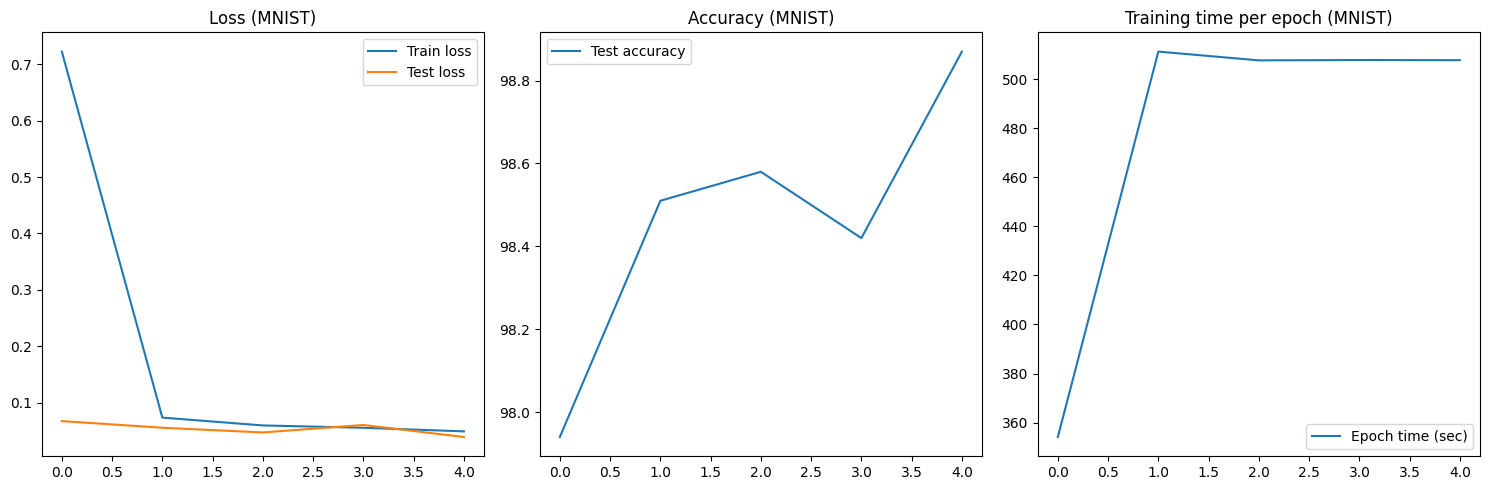

=== VGG-11 на Fashion-MNIST ===
📦 Устройство: cuda
Epoch 1/5: Train loss=0.7324, Test loss=0.4429, Acc=84.24%, Time=514.29 sec
Epoch 2/5: Train loss=0.3253, Test loss=0.3572, Acc=87.03%, Time=500.78 sec
Epoch 3/5: Train loss=0.2885, Test loss=0.3147, Acc=88.54%, Time=506.51 sec
Epoch 4/5: Train loss=0.2612, Test loss=0.2911, Acc=89.80%, Time=501.72 sec
Epoch 5/5: Train loss=0.2479, Test loss=0.3009, Acc=89.90%, Time=501.75 sec


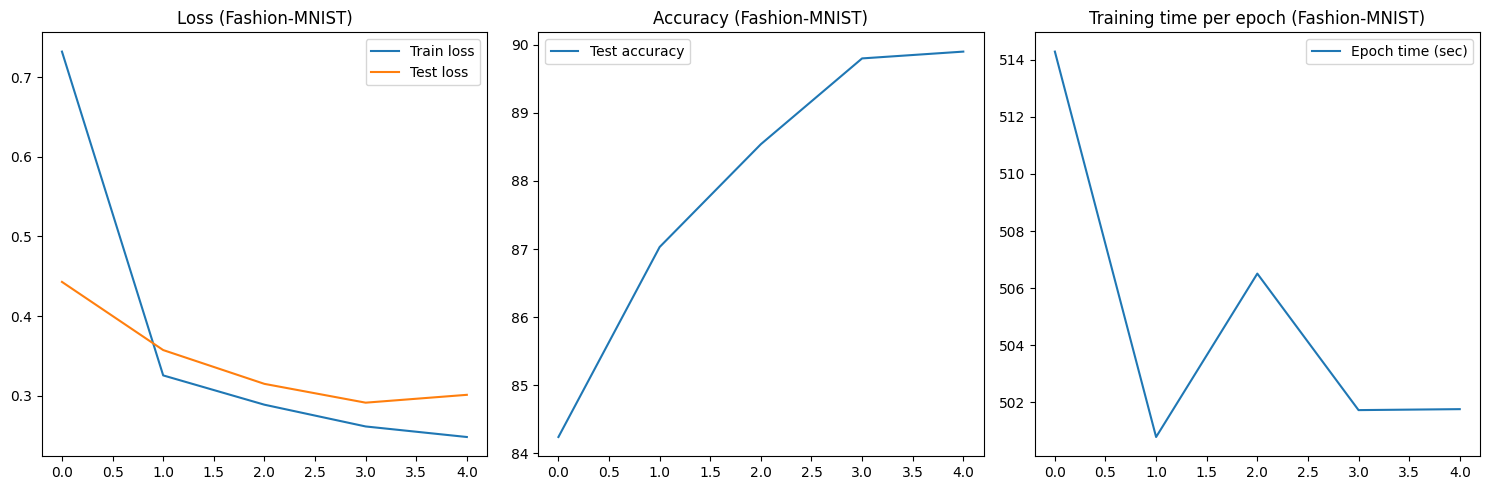

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import warnings

# --- 0. Ускорение и подавление предупреждений ---
torch.backends.cudnn.benchmark = True
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 1. Подготовка данных ---
transform = transforms.Compose([
    transforms.Resize(96),   # Уменьшаем до 96x96 вместо 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_fashion = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_mnist, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

train_loader_fashion = DataLoader(train_fashion, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader_fashion = DataLoader(test_fashion, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

# --- 2. VGG-11 с адаптацией ---
def build_vgg11(num_classes=10):
    model = models.vgg11(weights=None)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

# --- 3. Обучение и оценка ---
def train_and_evaluate(train_loader, test_loader, epochs=5, title="MNIST"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"📦 Устройство: {device}")
    model = build_vgg11(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, test_accs, times = [], [], [], []

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        running_loss = 0
        for data, target in train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_loader))

        # --- Оценка ---
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        epoch_time = time.time() - start_time
        times.append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train loss={train_losses[-1]:.4f}, "
              f"Test loss={test_losses[-1]:.4f}, "
              f"Acc={test_accs[-1]:.2f}%, "
              f"Time={epoch_time:.2f} sec")

    # --- Графики ---
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.title(f"Loss ({title})")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(test_accs, label="Test accuracy")
    plt.title(f"Accuracy ({title})")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(times, label="Epoch time (sec)")
    plt.title(f"Training time per epoch ({title})")
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- 4. Запуск обучения ---
print("=== VGG-11 на MNIST ===")
train_and_evaluate(train_loader_mnist, test_loader_mnist, epochs=5, title="MNIST")

print("=== VGG-11 на Fashion-MNIST ===")
train_and_evaluate(train_loader_fashion, test_loader_fashion, epochs=5, title="Fashion-MNIST")


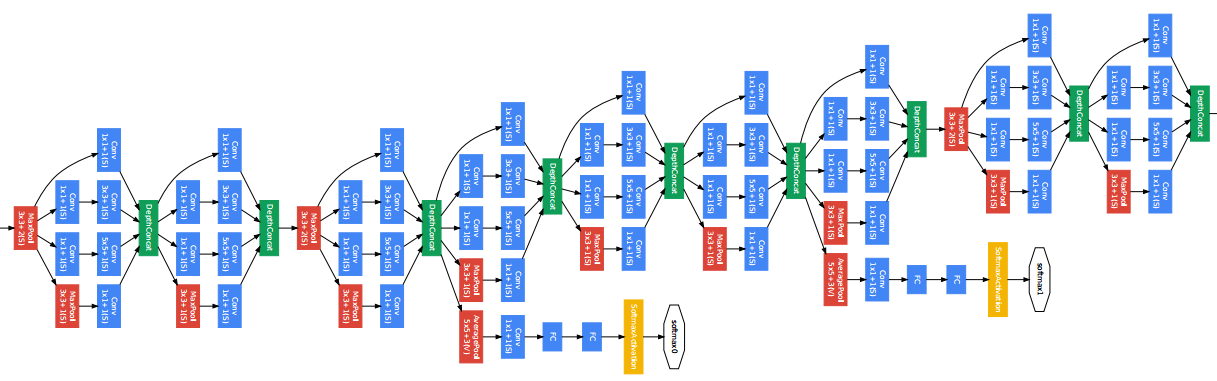

In [19]:
from IPython.display import Image, display

display(Image(filename='GoogLeNet.png'))

📚 Что из себя представляет GoogLeNet
Год: 2014

Авторы: команда Google (Szegedy et al.), статья “Going Deeper with Convolutions”.

Прорыв: победа в конкурсе ILSVRC‑2014 (ImageNet), ошибка топ‑5 снизилась до ~6,7% (лучше, чем у VGG).

Главная идея: вместо последовательных Conv‑слоёв использовать Inception‑модули — параллельные свёртки разных размеров (1×1, 3×3, 5×5) + pooling, а затем объединение их выходов.

🔎 Архитектура

Вход: изображение 224×224×3.
Начальные Conv + Pool слои для уменьшения размера.
9 Inception‑модулей, сгруппированных в несколько стадий.
Внутри Inception‑модуля:
1×1 свёртки для снижения размерности (экономия параметров).
3×3 и 5×5 свёртки для извлечения признаков разного масштаба.
MaxPooling для устойчивости.
Конкатенация всех выходов.
В конце — Global Average Pooling (вместо огромных FC‑слоёв, как в VGG).
Выход: 1000 классов (ImageNet).

🎯 Для чего используется

Классификация изображений (ImageNet и другие датасеты).
Feature extractor: Inception‑блоки применяются в детекции (например, Faster R‑CNN) и сегментации.
Мобильные и оптимизированные модели: идея 1×1 свёрток и экономии параметров повлияла на MobileNet, Xception и EfficientNet.
Исследования: GoogLeNet стал базой для последующих версий (Inception v2, v3, v4, Inception‑ResNet).

⏳ Актуальна ли сейчас
В продакшене: редко используется напрямую, так как появились более точные и эффективные модели (ResNet, EfficientNet, Vision Transformers).
В обучении: да, как пример архитектуры с модульным дизайном и идеей «многомасштабных признаков».
Влияние: Inception‑модули стали важным шагом к созданию лёгких и эффективных CNN.

📊 Итог

GoogLeNet — это первая сеть, которая показала, что можно строить глубокие и при этом эффективные CNN (всего ~5 млн параметров против 138 млн у VGG).
Сегодня она уступает по точности, но её идеи живут в современных архитектурах (MobileNet, EfficientNet).

=== GoogLeNet на MNIST ===
📦 Устройство: cuda
Epoch 1/5: Train loss=0.1354, Test loss=0.1808, Acc=94.44%, Time=80.06 sec
Epoch 2/5: Train loss=0.0581, Test loss=0.0360, Acc=98.91%, Time=67.28 sec
Epoch 3/5: Train loss=0.0448, Test loss=0.0387, Acc=98.83%, Time=69.82 sec
Epoch 4/5: Train loss=0.0386, Test loss=0.0330, Acc=99.00%, Time=67.59 sec
Epoch 5/5: Train loss=0.0353, Test loss=0.0254, Acc=99.24%, Time=67.51 sec


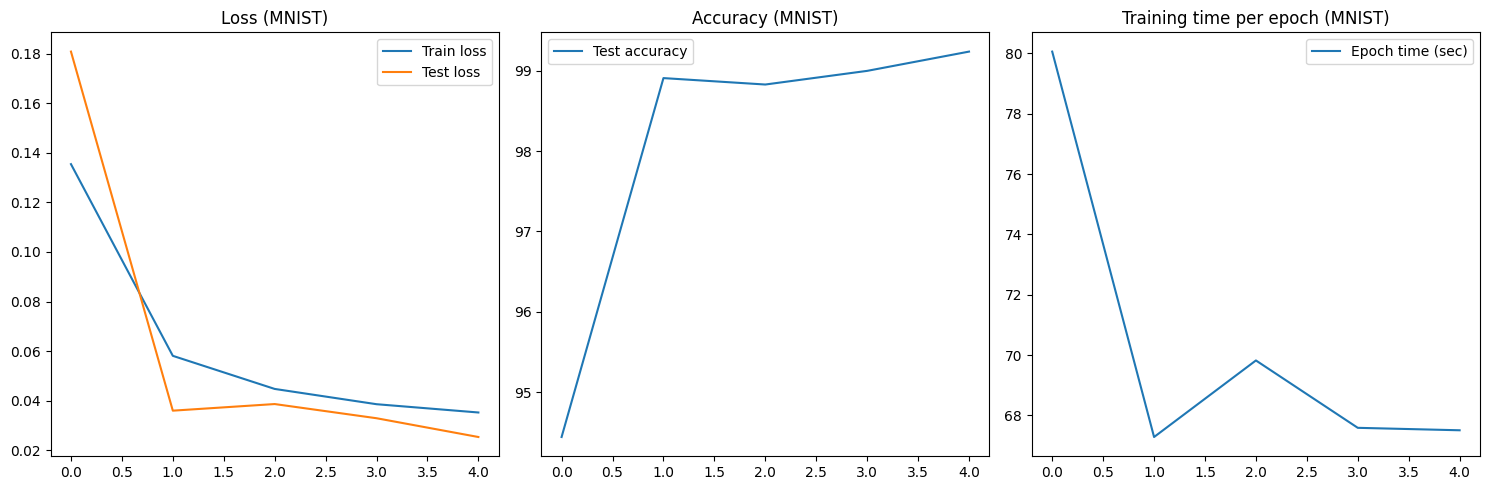

=== GoogLeNet на Fashion-MNIST ===
📦 Устройство: cuda
Epoch 1/5: Train loss=0.4908, Test loss=0.4204, Acc=85.01%, Time=67.99 sec
Epoch 2/5: Train loss=0.3079, Test loss=0.3811, Acc=86.59%, Time=67.57 sec
Epoch 3/5: Train loss=0.2664, Test loss=0.3303, Acc=88.48%, Time=67.40 sec
Epoch 4/5: Train loss=0.2387, Test loss=0.2650, Acc=90.49%, Time=67.78 sec
Epoch 5/5: Train loss=0.2210, Test loss=0.2947, Acc=89.16%, Time=67.65 sec


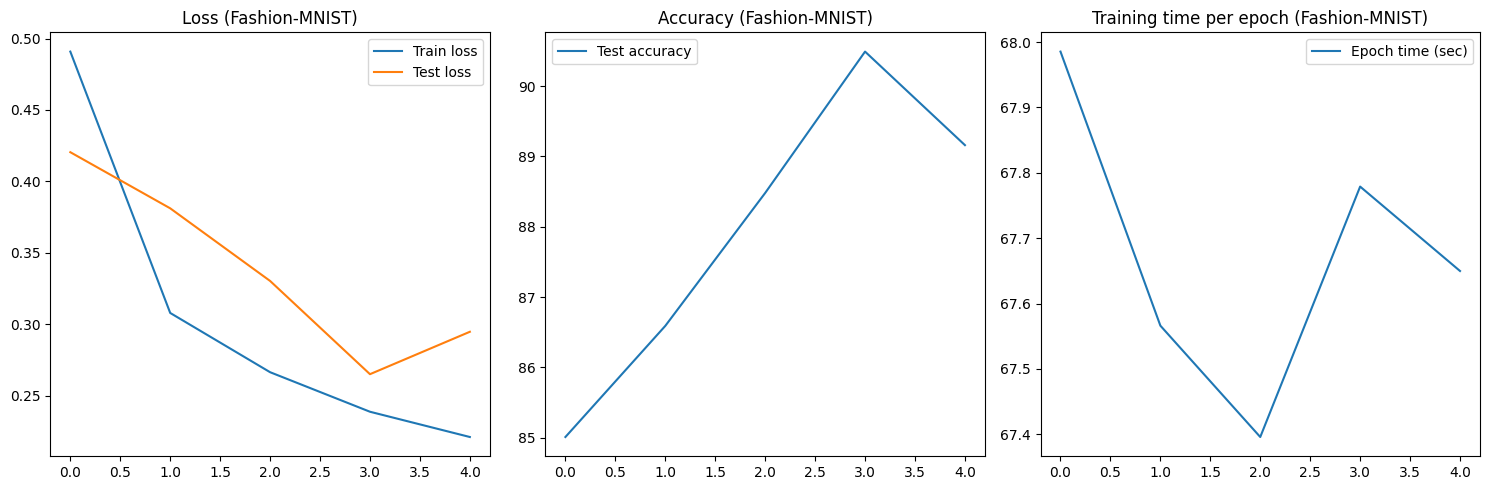

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import warnings

# --- 0. Ускорение и подавление предупреждений ---
torch.backends.cudnn.benchmark = True
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 1. Подготовка данных ---
transform = transforms.Compose([
    transforms.Resize(96),   # Уменьшаем до 96x96 вместо 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_fashion = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_mnist, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

train_loader_fashion = DataLoader(train_fashion, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader_fashion = DataLoader(test_fashion, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

# --- 2. GoogLeNet с адаптацией ---
def build_googlenet(num_classes=10):
    model = models.googlenet(weights=None, aux_logits=False, init_weights=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(1024, num_classes)
    return model

# --- 3. Обучение и оценка ---
def train_and_evaluate(train_loader, test_loader, epochs=5, title="MNIST"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"📦 Устройство: {device}")
    model = build_googlenet(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, test_accs, times = [], [], [], []

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        running_loss = 0
        for data, target in train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_loader))

        # --- Оценка ---
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        epoch_time = time.time() - start_time
        times.append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train loss={train_losses[-1]:.4f}, "
              f"Test loss={test_losses[-1]:.4f}, "
              f"Acc={test_accs[-1]:.2f}%, "
              f"Time={epoch_time:.2f} sec")

    # --- Графики ---
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.title(f"Loss ({title})")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(test_accs, label="Test accuracy")
    plt.title(f"Accuracy ({title})")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(times, label="Epoch time (sec)")
    plt.title(f"Training time per epoch ({title})")
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- 4. Запуск обучения ---
print("=== GoogLeNet на MNIST ===")
train_and_evaluate(train_loader_mnist, test_loader_mnist, epochs=5, title="MNIST")

print("=== GoogLeNet на Fashion-MNIST ===")
train_and_evaluate(train_loader_fashion, test_loader_fashion, epochs=5, title="Fashion-MNIST")


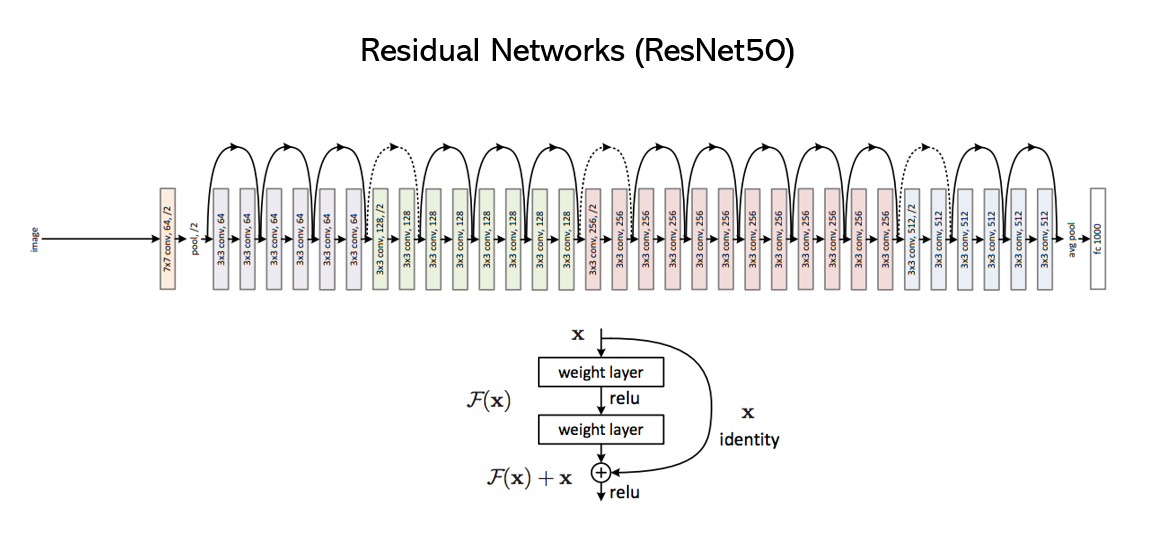

In [20]:
from IPython.display import Image, display

display(Image(filename='ResNet.png'))

📚 Что из себя представляет ResNet
Год: 2015

Авторы: команда Microsoft Research (He et al.).

Прорыв: победа в ILSVRC‑2015 (ImageNet), ошибка топ‑5 всего ~3,6% — лучше, чем у человека.

Главная идея: использование residual connections (skip‑connections).

В обычной глубокой сети при увеличении числа слоёв возникает проблема затухания/взрыва градиентов и деградации точности.
ResNet решает это, добавляя «короткие связи» (skip‑connections), которые позволяют сигналу и градиенту проходить напрямую, минуя несколько слоёв.
Если слой «не нужен», сеть просто копирует вход на выход.

🔎 Архитектура

Вход: изображение 224×224×3.
Начальные Conv + Pool слои.
Далее — Residual Blocks (каждый состоит из 2–3 Conv слоёв + skip‑connection).
Варианты глубины: ResNet‑18, ResNet‑34, ResNet‑50, ResNet‑101, ResNet‑152.
ResNet‑50 и глубже используют «bottleneck‑блоки» (1×1 → 3×3 → 1×1).
В конце — Global Average Pooling + FC (1000 классов для ImageNet).

🎯 Для чего используется

Классификация изображений (ImageNet, CIFAR, медицинские датасеты).
Feature extractor: ResNet часто используют как «спину» (backbone) в детекторах (Faster R‑CNN, Mask R‑CNN, YOLO).
Сегментация: U‑Net, DeepLab и другие архитектуры используют ResNet как основу.
Transfer learning: предобученные ResNet доступны в PyTorch (torchvision.models.resnet50(pretrained=True)) и Keras.
Исследования: ResNet стал стандартом для сравнения новых моделей.

⏳ Актуальна ли сейчас
Да, очень.
ResNet до сих пор используется как baseline и backbone в огромном числе задач.
Современные модели (EfficientNet, ConvNeXt, Vision Transformers) могут быть точнее и легче, но ResNet остаётся:
надёжным,
хорошо изученным,
быстрым в обучении,
удобным для transfer learning.

📊 Итог
ResNet — это архитектура, которая позволила строить очень глубокие сети (100+ слоёв) без деградации качества.
Она актуальна и сегодня: в продакшене и исследованиях ResNet‑50/101 остаются стандартом.
Её идея skip‑connections стала фундаментом для многих последующих архитектур (DenseNet, Inception‑ResNet, Transformer‑модели).

=== ResNet-18 на MNIST ===
📦 Устройство: cuda
Epoch 1/5: Train loss=0.0974, Test loss=0.0627, Acc=98.12%, Time=59.15 sec
Epoch 2/5: Train loss=0.0434, Test loss=0.0375, Acc=98.84%, Time=55.57 sec
Epoch 3/5: Train loss=0.0323, Test loss=0.0391, Acc=98.79%, Time=57.42 sec
Epoch 4/5: Train loss=0.0270, Test loss=0.0456, Acc=98.73%, Time=55.20 sec
Epoch 5/5: Train loss=0.0237, Test loss=0.0241, Acc=99.22%, Time=55.17 sec


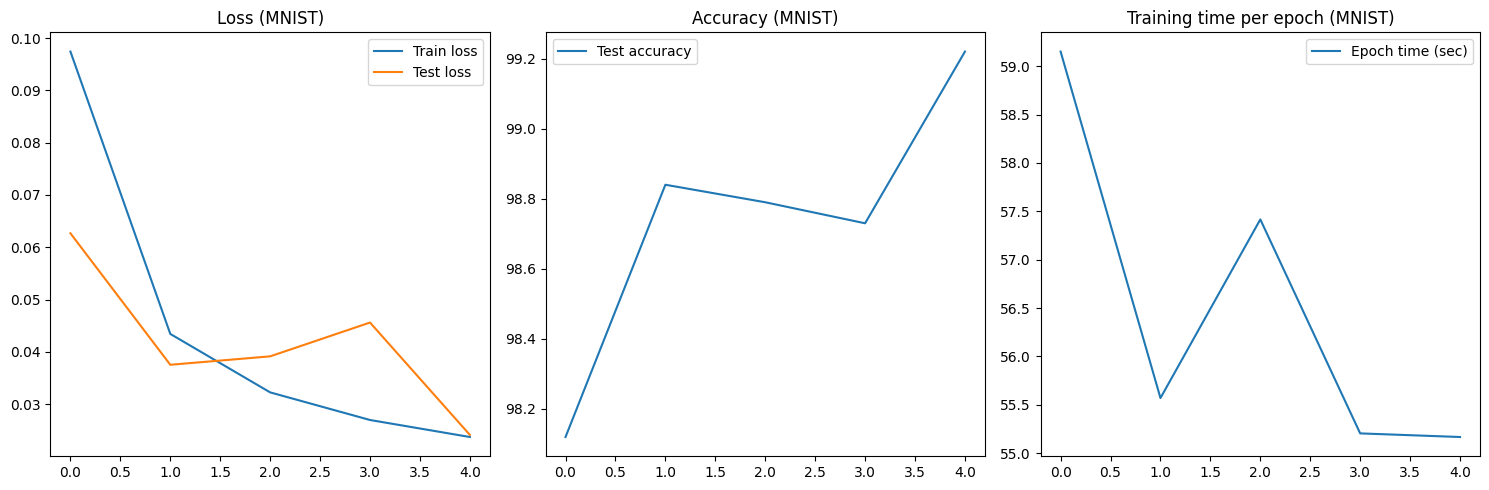

=== ResNet-18 на Fashion-MNIST ===
📦 Устройство: cuda
Epoch 1/5: Train loss=0.3644, Test loss=0.3021, Acc=88.98%, Time=55.11 sec
Epoch 2/5: Train loss=0.2473, Test loss=0.2667, Acc=90.41%, Time=55.39 sec
Epoch 3/5: Train loss=0.2041, Test loss=0.2254, Acc=91.92%, Time=55.38 sec
Epoch 4/5: Train loss=0.1778, Test loss=0.2502, Acc=90.94%, Time=55.20 sec
Epoch 5/5: Train loss=0.1531, Test loss=0.2419, Acc=91.23%, Time=55.18 sec


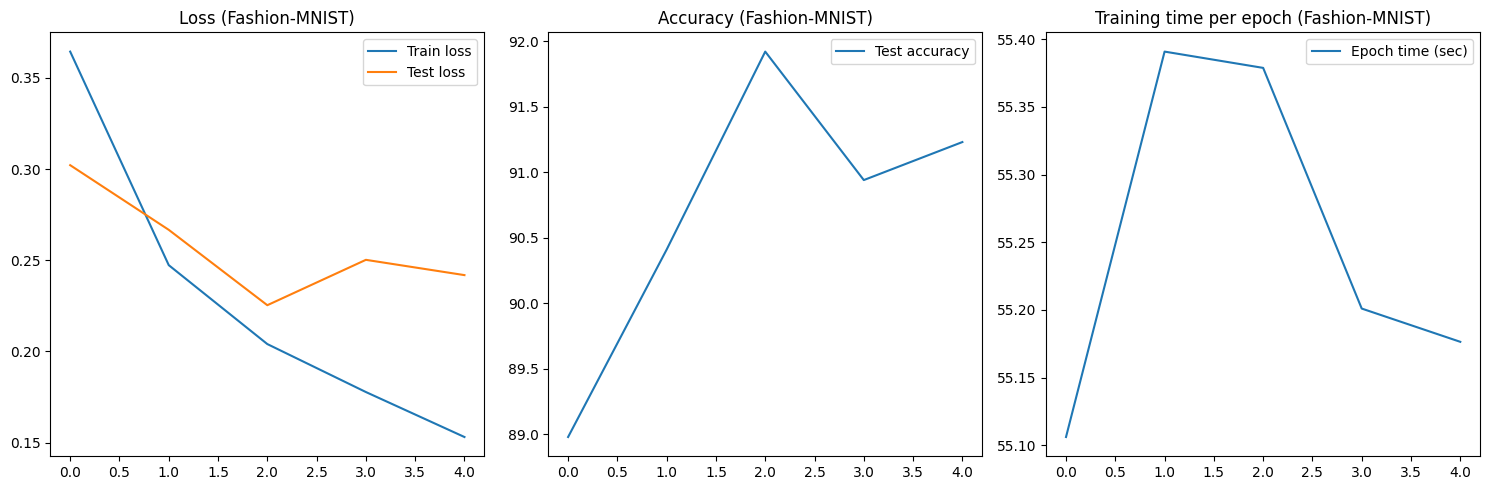

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import warnings

# --- 0. Ускорение и подавление предупреждений ---
torch.backends.cudnn.benchmark = True
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 1. Подготовка данных ---
transform = transforms.Compose([
    transforms.Resize(96),   # Уменьшаем до 96x96 вместо 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_fashion = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_mnist, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

train_loader_fashion = DataLoader(train_fashion, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader_fashion = DataLoader(test_fashion, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

# --- 2. ResNet-18 с адаптацией ---
def build_resnet18(num_classes=10):
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# --- 3. Обучение и оценка ---
def train_and_evaluate(train_loader, test_loader, epochs=5, title="MNIST"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"📦 Устройство: {device}")
    model = build_resnet18(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, test_accs, times = [], [], [], []

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        running_loss = 0
        for data, target in train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_loader))

        # --- Оценка ---
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        epoch_time = time.time() - start_time
        times.append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train loss={train_losses[-1]:.4f}, "
              f"Test loss={test_losses[-1]:.4f}, "
              f"Acc={test_accs[-1]:.2f}%, "
              f"Time={epoch_time:.2f} sec")

    # --- Графики ---
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.title(f"Loss ({title})")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(test_accs, label="Test accuracy")
    plt.title(f"Accuracy ({title})")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(times, label="Epoch time (sec)")
    plt.title(f"Training time per epoch ({title})")
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- 4. Запуск обучения ---
print("=== ResNet-18 на MNIST ===")
train_and_evaluate(train_loader_mnist, test_loader_mnist, epochs=5, title="MNIST")

print("=== ResNet-18 на Fashion-MNIST ===")
train_and_evaluate(train_loader_fashion, test_loader_fashion, epochs=5, title="Fashion-MNIST")


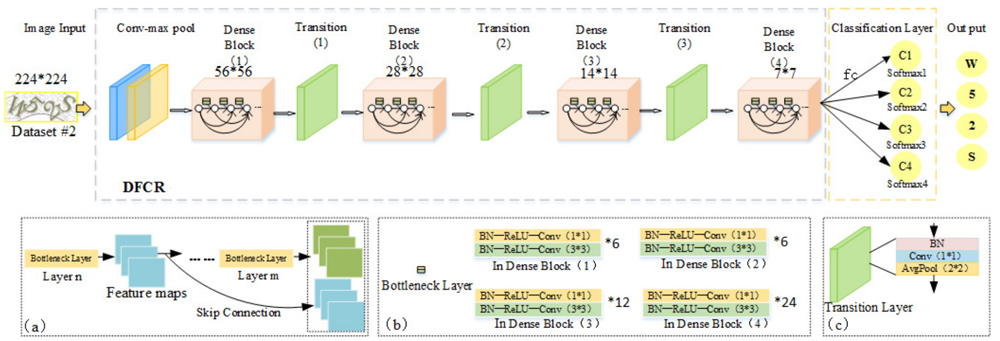

In [21]:
from IPython.display import Image, display

display(Image(filename='DenseNet.jpg'))

📚 Что из себя представляет DenseNet
Год: 2017

Авторы: Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger (“Densely Connected Convolutional Networks”).

Главная идея: каждый слой получает входы от всех предыдущих слоёв и передаёт свои выходы всем последующим.

В ResNet есть skip‑connections через несколько слоёв.

В DenseNet — dense‑connections: слой 𝐿
 соединён со всеми слоями 0,1,2,...,𝐿−1.

Архитектура:

Состоит из Dense Blocks (плотно связанных слоёв).
Между блоками — Transition Layers (Conv 1×1 + Pooling), которые уменьшают размерность.
Каждый слой внутри блока добавляет новые признаки, а не переобучает старые.
Параметры: гораздо меньше, чем у VGG или ResNet при сопоставимой точности, потому что признаки переиспользуются.

🎯 Для чего используется

Классификация изображений (ImageNet, CIFAR).
Медицина: анализ рентгенов, МРТ, КТ (DenseNet хорошо работает на небольших датасетах).
Сегментация: DenseNet часто используют как backbone в U‑Net‑подобных архитектурах.
Transfer learning: предобученные DenseNet доступны в PyTorch (torchvision.models.densenet121(pretrained=True)) и Keras.

⏳ Актуальна ли сейчас
Да, но не как основной стандарт.
DenseNet показал, что можно строить очень глубокие сети без взрыва параметров и переобучения.
Сегодня его вытеснили более эффективные модели (EfficientNet, ConvNeXt, Vision Transformers).
Однако DenseNet до сих пор применяют:
в медицине (где важна интерпретируемость и переиспользование признаков),
в задачах, где мало данных (dense‑связи помогают лучше обучаться).

📊 Итог
DenseNet — это развитие идей ResNet: вместо «редких» skip‑connections используется «полная» связность.
Он экономичнее по параметрам, чем VGG и ResNet, и показывает отличные результаты на ImageNet.
Сегодня DenseNet — это важная архитектура для обучения и исследований, но в продакшене чаще используют EfficientNet или трансформеры.

=== DenseNet-121 на MNIST ===
📦 Устройство: cuda
Epoch 1/5: Train loss=0.0998, Test loss=0.0354, Acc=98.80%, Time=174.02 sec
Epoch 2/5: Train loss=0.0420, Test loss=0.0322, Acc=99.04%, Time=156.58 sec
Epoch 3/5: Train loss=0.0320, Test loss=0.0330, Acc=98.98%, Time=157.14 sec
Epoch 4/5: Train loss=0.0283, Test loss=0.0230, Acc=99.25%, Time=157.14 sec
Epoch 5/5: Train loss=0.0245, Test loss=0.0382, Acc=98.86%, Time=157.15 sec


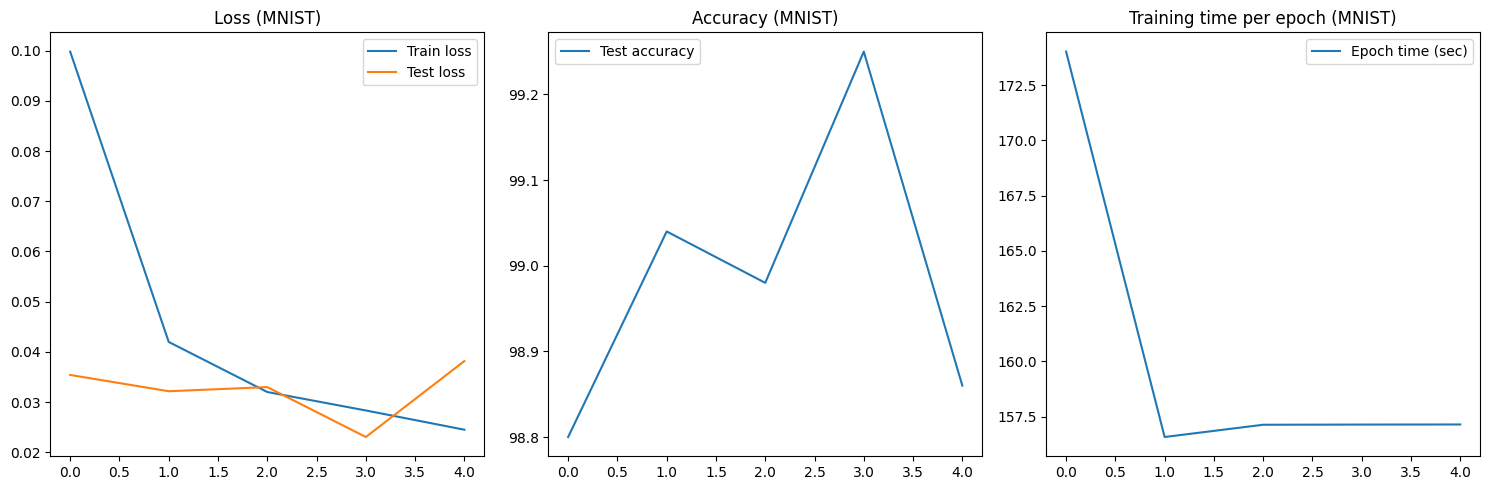

=== DenseNet-121 на Fashion-MNIST ===
📦 Устройство: cuda
Epoch 1/5: Train loss=0.3940, Test loss=0.3597, Acc=85.72%, Time=213.13 sec
Epoch 2/5: Train loss=0.2577, Test loss=0.2728, Acc=90.12%, Time=251.13 sec
Epoch 3/5: Train loss=0.2211, Test loss=0.2291, Acc=91.61%, Time=251.21 sec
Epoch 4/5: Train loss=0.1955, Test loss=0.2252, Acc=91.92%, Time=251.33 sec
Epoch 5/5: Train loss=0.1757, Test loss=0.2193, Acc=92.32%, Time=251.15 sec


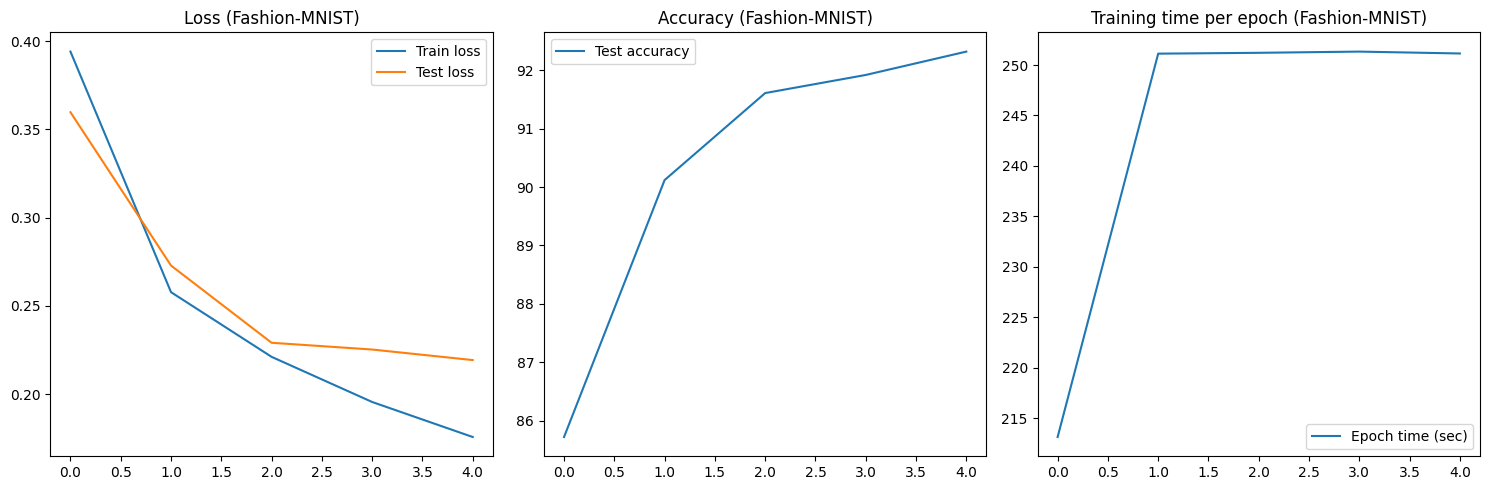

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import warnings

# --- 0. Ускорение и подавление предупреждений ---
torch.backends.cudnn.benchmark = True
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 1. Подготовка данных ---
transform = transforms.Compose([
    transforms.Resize(96),   # Уменьшаем до 96x96 вместо 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_fashion = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_mnist, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

train_loader_fashion = DataLoader(train_fashion, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader_fashion = DataLoader(test_fashion, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

# --- 2. DenseNet-121 с адаптацией ---
def build_densenet121(num_classes=10):
    model = models.densenet121(weights=None)
    model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

# --- 3. Обучение и оценка ---
def train_and_evaluate(train_loader, test_loader, epochs=5, title="MNIST"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"📦 Устройство: {device}")
    model = build_densenet121(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, test_accs, times = [], [], [], []

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        running_loss = 0
        for data, target in train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_loader))

        # --- Оценка ---
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        epoch_time = time.time() - start_time
        times.append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train loss={train_losses[-1]:.4f}, "
              f"Test loss={test_losses[-1]:.4f}, "
              f"Acc={test_accs[-1]:.2f}%, "
              f"Time={epoch_time:.2f} sec")

    # --- Графики ---
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.title(f"Loss ({title})")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(test_accs, label="Test accuracy")
    plt.title(f"Accuracy ({title})")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(times, label="Epoch time (sec)")
    plt.title(f"Training time per epoch ({title})")
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- 4. Запуск обучения ---
print("=== DenseNet-121 на MNIST ===")
train_and_evaluate(train_loader_mnist, test_loader_mnist, epochs=5, title="MNIST")

print("=== DenseNet-121 на Fashion-MNIST ===")
train_and_evaluate(train_loader_fashion, test_loader_fashion, epochs=5, title="Fashion-MNIST")


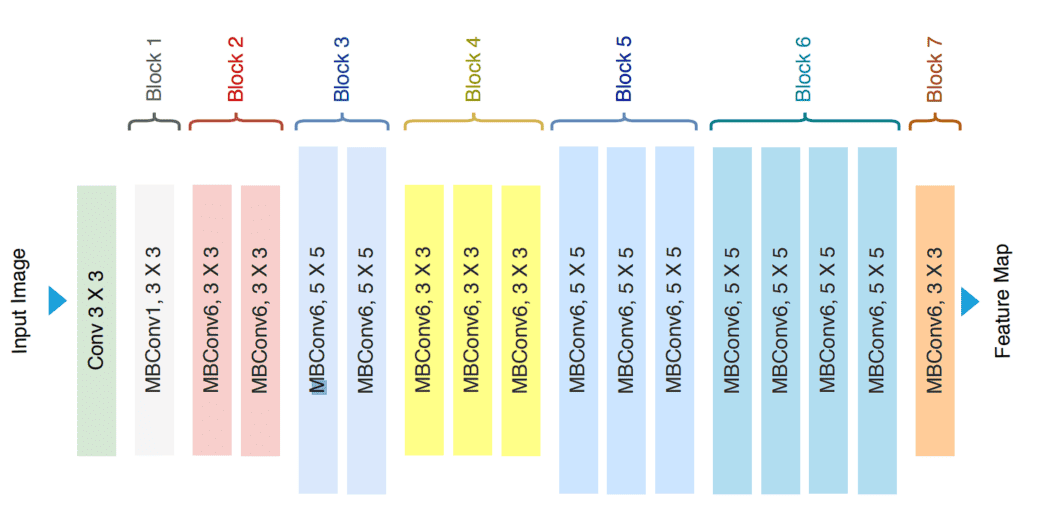

In [22]:
from IPython.display import Image, display

display(Image(filename='EfficientNet.png'))

📚 Что из себя представляет EfficientNet
Год: 2019

Авторы: Google AI (Tan & Le, “EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks”).

Главная идея: вместо того чтобы увеличивать сеть только по глубине (как ResNet) или только по ширине (как VGG), EfficientNet использует составное масштабирование (compound scaling).

Масштабируются одновременно:

глубина (число слоёв),
ширина (число каналов),
разрешение входного изображения.

Всё это делается по сбалансированной формуле, что даёт максимум точности при минимальных FLOPs.

Архитектура:

Основана на Mobile Inverted Bottleneck Convolution (MBConv) из MobileNetV2.
Использует squeeze‑and‑excitation блоки для адаптивного взвешивания каналов.
Базовая модель — EfficientNet‑B0, далее масштабируется до B1–B7.

🎯 Для чего используется

Классификация изображений (ImageNet, CIFAR, медицинские датасеты).
Обнаружение объектов (EfficientDet — детектор на базе EfficientNet).
Сегментация (варианты U‑Net с EfficientNet‑backbone).
Transfer learning: EfficientNet часто используют как предобученный backbone в PyTorch/Keras.
Мобильные и edge‑устройства: благодаря высокой эффективности, EfficientNet подходит для смартфонов и IoT.

⏳ Актуальна ли сейчас

Да, но с оговорками:
EfficientNet долгое время был state‑of‑the‑art по соотношению точность/производительность.
Сегодня его частично вытеснили ConvNeXt и Vision Transformers (ViT, Swin‑Transformer).
Тем не менее EfficientNet остаётся очень популярным в продакшене, особенно там, где важны скорость и компактность.
EfficientNetV2 (2021) — улучшенная версия, быстрее обучается и работает эффективнее.

📊 Итог

EfficientNet — это архитектура, которая впервые показала, как правильно масштабировать CNN.
Она актуальна и сегодня, особенно для мобильных приложений и задач, где важен баланс точности и скорости.
В «тяжёлых» задачах (например, большие датасеты, SOTA‑результаты) её постепенно заменяют трансформеры, но EfficientNet остаётся золотым стандартом для практики.

=== EfficientNet-B0 на MNIST ===
📦 Устройство: cuda
Epoch 1/5: Train loss=0.2172, Test loss=0.0394, Acc=98.71%, Time=109.88 sec
Epoch 2/5: Train loss=0.0581, Test loss=0.0356, Acc=98.99%, Time=101.63 sec
Epoch 3/5: Train loss=0.0511, Test loss=0.0250, Acc=99.28%, Time=583.63 sec
Epoch 4/5: Train loss=0.0372, Test loss=0.0285, Acc=99.19%, Time=568.11 sec
Epoch 5/5: Train loss=0.0342, Test loss=0.0311, Acc=99.07%, Time=568.40 sec


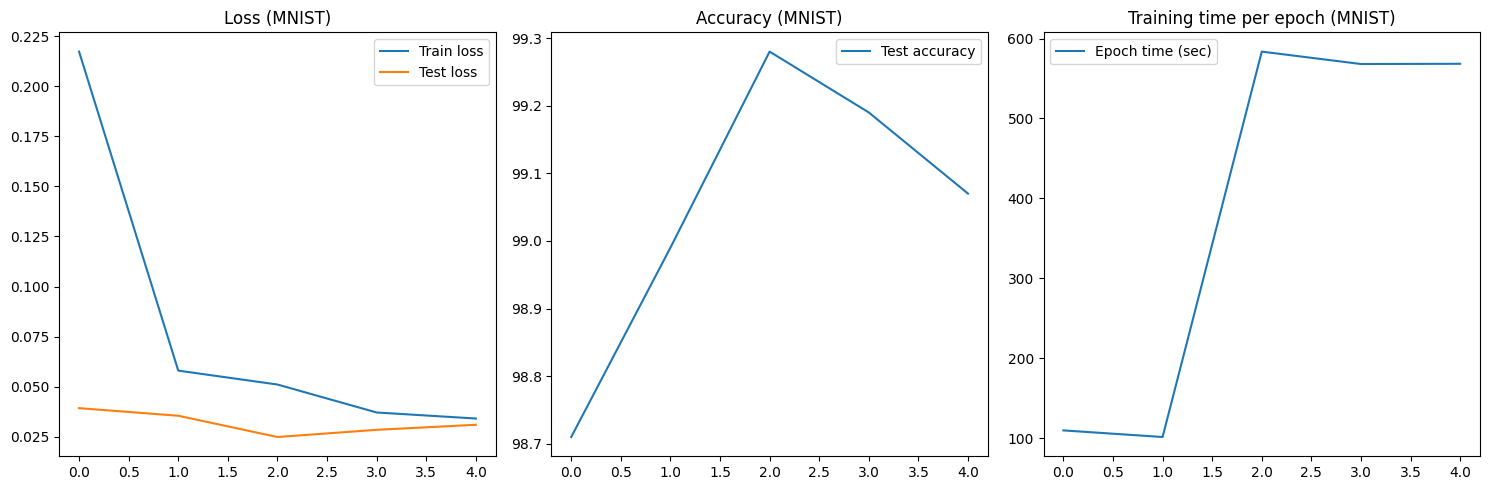

=== EfficientNet-B0 на Fashion-MNIST ===
📦 Устройство: cuda
Epoch 1/5: Train loss=0.5253, Test loss=0.3873, Acc=86.73%, Time=563.58 sec
Epoch 2/5: Train loss=0.2803, Test loss=0.2701, Acc=90.40%, Time=563.51 sec
Epoch 3/5: Train loss=0.2371, Test loss=0.2568, Acc=90.80%, Time=563.69 sec
Epoch 4/5: Train loss=0.2079, Test loss=0.2345, Acc=91.72%, Time=563.60 sec
Epoch 5/5: Train loss=0.1883, Test loss=0.2338, Acc=91.65%, Time=563.68 sec


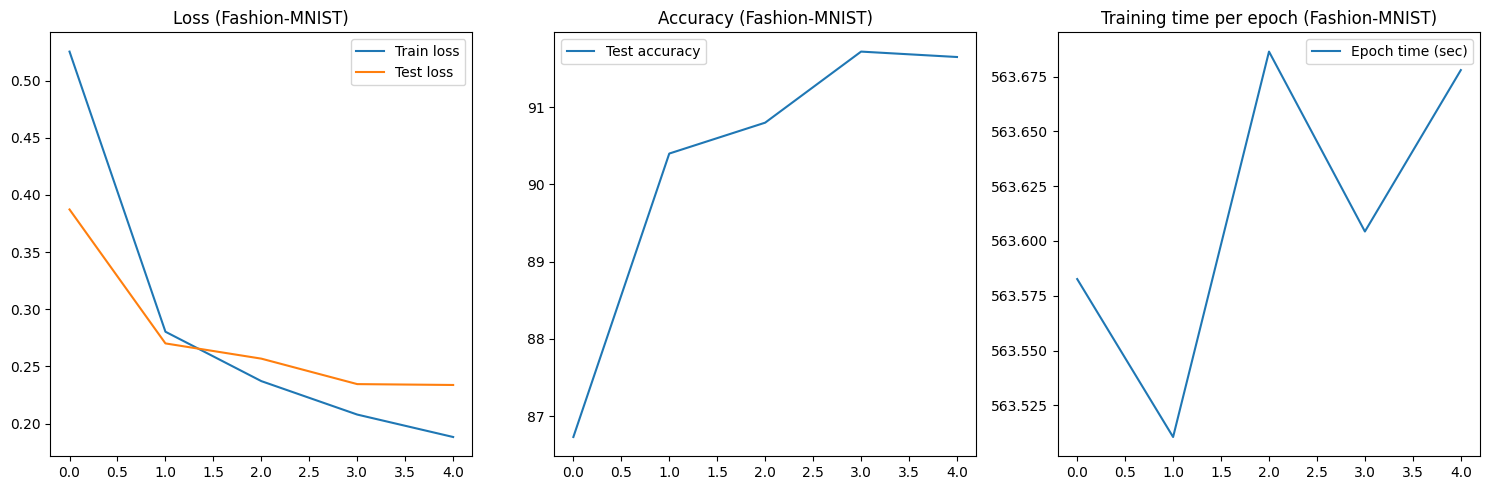

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import warnings

# --- 0. Ускорение и подавление предупреждений ---
torch.backends.cudnn.benchmark = True
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 1. Подготовка данных ---
transform = transforms.Compose([
    transforms.Resize(96),   # Уменьшаем до 96x96 вместо 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_fashion = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_mnist, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

train_loader_fashion = DataLoader(train_fashion, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader_fashion = DataLoader(test_fashion, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

# --- 2. EfficientNet-B0 с адаптацией ---
def build_efficientnet_b0(num_classes=10):
    model = models.efficientnet_b0(weights=None)
    # Меняем первый слой под 1 канал
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    # Меняем последний слой под 10 классов
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# --- 3. Обучение и оценка ---
def train_and_evaluate(train_loader, test_loader, epochs=5, title="MNIST"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"📦 Устройство: {device}")
    model = build_efficientnet_b0(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses, test_accs, times = [], [], [], []

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        running_loss = 0
        for data, target in train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_loader))

        # --- Оценка ---
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

        epoch_time = time.time() - start_time
        times.append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train loss={train_losses[-1]:.4f}, "
              f"Test loss={test_losses[-1]:.4f}, "
              f"Acc={test_accs[-1]:.2f}%, "
              f"Time={epoch_time:.2f} sec")

    # --- Графики ---
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.title(f"Loss ({title})")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(test_accs, label="Test accuracy")
    plt.title(f"Accuracy ({title})")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(times, label="Epoch time (sec)")
    plt.title(f"Training time per epoch ({title})")
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- 4. Запуск обучения ---
print("=== EfficientNet-B0 на MNIST ===")
train_and_evaluate(train_loader_mnist, test_loader_mnist, epochs=5, title="MNIST")

print("=== EfficientNet-B0 на Fashion-MNIST ===")
train_and_evaluate(train_loader_fashion, test_loader_fashion, epochs=5, title="Fashion-MNIST")


Откуда можно импортировать?


📦 PyTorch (torchvision.models)
В PyTorch почти все современные и классические модели доступны прямо «из коробки» в torchvision.models:

Пример импортов:
python
import torchvision.models as models

alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
googlenet = models.googlenet(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
efficientnet_b0 = models.efficientnet_b0(pretrained=True)
✅ AlexNet, VGG, GoogLeNet, ResNet, DenseNet, EfficientNet — доступны напрямую.

❌ LeNet — в torchvision нет, но легко реализуется вручную (несколько Conv+Pool+FC слоёв). Есть готовые реализации на GitHub (например, этот репозиторий).

📦 TensorFlow / Keras (tf.keras.applications)
В Keras тоже есть большинство моделей:

python
from tensorflow.keras.applications import (
    VGG16, VGG19,
    ResNet50, ResNet101, ResNet152,
    DenseNet121, DenseNet169, DenseNet201,
    EfficientNetB0, EfficientNetB7,
    InceptionV3, InceptionResNetV2
)

vgg = VGG16(weights="imagenet")
resnet = ResNet50(weights="imagenet")
densenet = DenseNet121(weights="imagenet")
efficientnet = EfficientNetB0(weights="imagenet")
inception = InceptionV3(weights="imagenet")
✅ VGG, ResNet, DenseNet, EfficientNet, Inception (GoogLeNet v3) — есть.

❌ AlexNet и LeNet — отсутствуют, их нужно реализовать вручную или взять из сторонних репозиториев.

📊 Итого
PyTorch: почти всё есть в torchvision.models, кроме LeNet.
Keras: есть VGG, ResNet, DenseNet, EfficientNet, Inception; нет AlexNet и LeNet.
LeNet: всегда пишется вручную (он очень простой).
AlexNet: есть в PyTorch, но в Keras — только сторонние реализации.